# Neural Machine Translation

Welcome to your first programming assignment for this week! 

You will build a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). You will do this using an attention model, one of the most sophisticated sequence to sequence models. 

This notebook was produced together with NVIDIA's Deep Learning Institute. 

Let's load all the packages you will need for this assignment.

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 1 - Translating human readable dates into machine readable dates

The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. However, language translation requires massive datasets and usually takes days of training on GPUs. To give you a place to experiment with these models even without using massive datasets, we will instead use a simpler "date translation" task. 

The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 



<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

### 1.1 - Dataset

We will train the model on a dataset of 10000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9841.09it/s]


In [3]:
inv_machine_vocab

{0: '-',
 1: '0',
 2: '1',
 3: '2',
 4: '3',
 5: '4',
 6: '5',
 7: '6',
 8: '7',
 9: '8',
 10: '9'}

In [4]:
dataset[:5]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07')]

In [5]:
machine_vocab

{'-': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

You've loaded:
- `dataset`: a list of tuples of (human readable date, machine readable date)
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index 
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long). 

In [6]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


You now have:
- `X`: a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in `machine_vocab`. You should have `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character thanks to `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character thanks to `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9). 


Lets also look at some examples of preprocessed training examples. Feel free to play with `index` in the cell below to navigate the dataset and see how source/target dates are preprocessed. 

In [7]:
index = 4
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: monday march 7 1983
Target date: 1983-03-07

Source after preprocessing (indices): [24 26 25 16 13 34  0 24 13 28 15 20  0 10  0  4 12 11  6 36 36 36 36 36 36
 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10  9  4  0  1  4  0  1  8]

Source after preprocessing (one-hot): [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Target after preprocessing (one-hot): [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.

## 2 - Neural machine translation with attention

If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 


### 2.1 - Attention mechanism

In this part, you will implement the attention mechanism presented in the lecture videos. Here is a figure to remind you how the model works. The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>



Here are some properties of the model that you may notice: 

- There are two separate LSTMs in this model (see diagram on the left). Because the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism, we will call it *pre-attention* Bi-LSTM. The LSTM at the top of the diagram comes *after* the attention mechanism, so we will call it the *post-attention* LSTM. The pre-attention Bi-LSTM goes through $T_x$ time steps; the post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes $s^{\langle t \rangle}, c^{\langle t \rangle}$ from one time step to the next. In the lecture videos, we were using only a basic RNN for the post-activation sequence model, so the state captured by the RNN output activations $s^{\langle t\rangle}$. But since we are using an LSTM here, the LSTM has both the output activation $s^{\langle t\rangle}$ and the hidden cell state $c^{\langle t\rangle}$. However, unlike previous text generation examples (such as Dinosaurus in week 1), in this model the post-activation LSTM at time $t$ does will not take the specific generated $y^{\langle t-1 \rangle}$ as input; it only takes $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ as input. We have designed the model this way, because (unlike language generation where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date. 

- We use $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-LSTM. 

- The diagram on the right uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times, and then `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ to compute $e^{\langle t, t'}$, which is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$. We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 

Lets implement this model. You will start by implementing two functions: `one_step_attention()` and `model()`.

**1) `one_step_attention()`**: At step $t$, given all the hidden states of the Bi-LSTM ($[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$) and the previous hidden state of the second LSTM ($s^{<t-1>}$), `one_step_attention()` will compute the attention weights ($[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$) and output the context vector (see Figure  1 (right) for details):
$$context^{<t>} = \sum_{t' = 0}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

Note that we are denoting the attention in this notebook $context^{\langle t \rangle}$. In the lecture videos, the context was denoted $c^{\langle t \rangle}$, but here we are calling it $context^{\langle t \rangle}$ to avoid confusion with the (post-attention) LSTM's internal memory cell variable, which is sometimes also denoted $c^{\langle t \rangle}$. 
  
**2) `model()`**: Implements the entire model. It first runs the input through a Bi-LSTM to get back $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. Then, it calls `one_step_attention()` $T_y$ times (`for` loop). At each iteration of this loop, it gives the computed context vector $c^{<t>}$ to the second LSTM, and runs the output of the LSTM through a dense layer with softmax activation to generate a prediction $\hat{y}^{<t>}$. 



**Exercise**: Implement `one_step_attention()`. The function `model()` will call the layers in `one_step_attention()` $T_y$ using a for-loop, and it is important that all $T_y$ copies have the same weights. I.e., it should not re-initiaiize the weights every time. In other words, all $T_y$ steps should have shared weights. Here's how you can implement layers with shareable weights in Keras:
1. Define the layer objects (as global variables for examples).
2. Call these objects when propagating the input.

We have defined the layers you need as global variables. Please run the following cells to create them. Please check the Keras documentation to make sure you understand what these layers are: [RepeatVector()](https://keras.io/layers/core/#repeatvector), [Concatenate()](https://keras.io/layers/merge/#concatenate), [Dense()](https://keras.io/layers/core/#dense), [Activation()](https://keras.io/layers/core/#activation), [Dot()](https://keras.io/layers/merge/#dot).

In [30]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

Now you can use these layers to implement `one_step_attention()`. In order to propagate a Keras tensor object X through one of these layers, use `layer(X)` (or `layer([X,Y])` if it requires multiple inputs.), e.g. `densor(X)` will propagate X through the `Dense(1)` layer defined above.

In [31]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    #repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([s_prev, a])
    #concatenator([s_prev, a])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat) 
    #densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    #densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    #activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    #dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

You will be able to check the expected output of `one_step_attention()` after you've coded the `model()` function.

**Exercise**: Implement `model()` as explained in figure 2 and the text above. Again, we have defined global layers that will share weights to be used in `model()`.

In [32]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

Now you can use these layers $T_y$ times in a `for` loop to generate the outputs, and their parameters will not be reinitialized. You will have to carry out the following steps: 

1. Propagate the input into a [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) [LSTM](https://keras.io/layers/recurrent/#lstm)
2. Iterate for $t = 0, \dots, T_y-1$: 
    1. Call `one_step_attention()` on $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$ and $s^{<t-1>}$ to get the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. Remember pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM using `initial_state= [previous hidden state, previous cell state]`. Get back the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.
    3. Apply a softmax layer to $s^{<t>}$, get the output. 
    4. Save the output by adding it to the list of outputs.

3. Create your Keras model instance, it should have three inputs ("inputs", $s^{<0>}$ and $c^{<0>}$) and output the list of "outputs".

In [33]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    #Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a,s)
        #one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s,c])
        #post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        #output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
        #outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    #Model(inputs=[X, s0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your model.

In [34]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

Let's get a summary of the model to check if it matches the expected output.

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_6[0][0]                     
                                                                 lstm_6[1][0]                     
                                                                 lstm_6[2][0]                     
          

**Expected Output**:

Here is the summary you should see
<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 64)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 64) 
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 128) 
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 64)
        </td>
    </tr>
           <tr>
        <td>
            **dense_3's output shape **
        </td>
        <td>
         (None, 11) 
        </td>
    </tr>
</table>


As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, a custom [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers) (`learning rate = 0.005`, $\beta_1 = 0.9$, $\beta_2 = 0.999$, `decay = 0.01`)  and `['accuracy']` metrics:

In [36]:
### START CODE HERE ### (≈2 lines)
opt = model.compile(optimizer=Adam(lr= 0.005, beta_1=0.9, beta_2=0.999, decay=0.01), metrics=['accuracy'], loss="categorical_crossentropy")
#model.compile(optimizer=Adam(lr = 0.005, beta_1=0.9 , beta_2=0.999 , decay = 0.01), 
                    #loss="categorical_crossentropy",
                    #metrics=["accuracy"])
opt
### END CODE HERE ###

The last step is to define all your inputs and outputs to fit the model:
- You already have X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- You need to create `s0` and `c0` to initialize your `post_activation_LSTM_cell` with 0s.
- Given the `model()` you coded, you need the "outputs" to be a list of 11 elements of shape (m, T_y). So that: `outputs[i][0], ..., outputs[i][Ty]` represent the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). More generally, `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [37]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Let's now fit the model and run it for one epoch.

In [38]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/2
10000/10000 [==============================] - ETA: 19:38 - loss: 23.9947 - dense_7_loss: 2.4005 - dense_7_acc: 0.0100 - dense_7_acc_1: 0.0000e+00 - dense_7_acc_2: 0.1900 - dense_7_acc_3: 0.1000 - dense_7_acc_4: 0.0700 - dense_7_acc_5: 0.0000e+00 - dense_7_acc_6: 0.0400 - dense_7_acc_7: 0.0700 - dense_7_acc_8: 0.0100 - dense_7_acc_9: 0.1100 - ETA: 9:51 - loss: 23.8198 - dense_7_loss: 2.4095 - dense_7_acc: 0.0050 - dense_7_acc_1: 0.0000e+00 - dense_7_acc_2: 0.0950 - dense_7_acc_3: 0.0500 - dense_7_acc_4: 0.5350 - dense_7_acc_5: 0.0000e+00 - dense_7_acc_6: 0.0200 - dense_7_acc_7: 0.5350 - dense_7_acc_8: 0.0050 - dense_7_acc_9: 0.0550 

While training you can see the loss as well as the accuracy on each of the 10 positions of the output. The table below gives you an example of what the accuracies could be if the batch had 2 examples: 

<img src="images/table.png" style="width:700;height:200px;"> <br>
<caption><center>Thus, `dense_2_acc_8: 0.89` means that you are predicting the 7th character of the output correctly 89% of the time in the current batch of data. </center></caption>


We have run this model for longer, and saved the weights. Run the next cell to load our weights. (By training a model for several minutes, you should be able to obtain a model of similar accuracy, but loading our model will save you time.) 

In [19]:
model.load_weights('models/model.h5')

You can now see the results on new examples.

In [39]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

ValueError: Error when checking : expected input_4 to have 3 dimensions, but got array with shape (37, 30)

You can also change these examples to test with your own examples. The next part will give you a better sense on what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 

## 3 - Visualizing Attention (Optional / Ungraded)

Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (say the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what part of the output is looking at what part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We see also that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 



### 3.1 - Getting the activations from the network

Lets now visualize the attention values in your network. We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_1[9][0]                     
                                                                   lstm_1[10][0]                    
                                                                   lstm_1[11][0]           

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Lets get the activations from this layer.

The function `attention_map()` pulls out the attention values from your model and plots them.

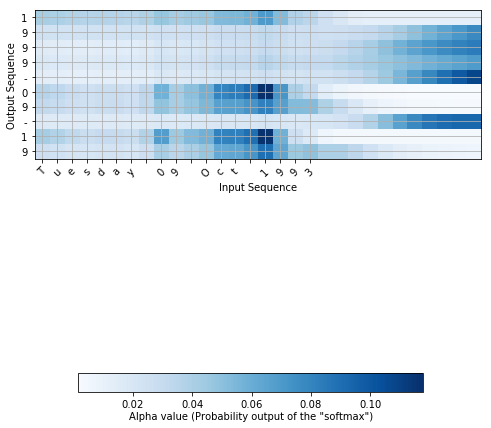

In [40]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)

On the generated plot you can observe the values of the attention weights for each character of the predicted output. Examine this plot and check that where the network is paying attention makes sense to you.

In the date translation application, you will observe that most of the time attention helps predict the year, and hasn't much impact on predicting the day/month.

### Congratulations!


You have come to the end of this assignment 

<font color='blue'> **Here's what you should remember from this notebook**:

- Machine translation models can be used to map from one sequence to another. They are useful not just for translating human languages (like French->English) but also for tasks like date format translation. 
- An attention mechanism allows a network to focus on the most relevant parts of the input when producing a specific part of the output. 
- A network using an attention mechanism can translate from inputs of length $T_x$ to outputs of length $T_y$, where $T_x$ and $T_y$ can be different. 
- You can visualize attention weights $\alpha^{\langle t,t' \rangle}$ to see what the network is paying attention to while generating each output.

Congratulations on finishing this assignment! You are now able to implement an attention model and use it to learn complex mappings from one sequence to another. 